## Netflix

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Import data

# Training Data
df_train=pd.read_csv('./ua.base',sep='\t',header=None,engine='python')

# Test Data
df_test=pd.read_csv('./ua.test',sep='\t',header=None,engine='python')

In [3]:
num_user=943
num_item=1682

In [4]:
# user-item matrix
def rating_matrix(df):
    R=np.zeros((num_user,num_item))
    df.columns=['user_id','item_id','rating','timestamp']
    for index in range(len(df)):
        u=df['user_id'][index]-1
        i=df['item_id'][index]-1
        R[u,i]=df['rating'][index]
    return R

In [5]:
# evaluation using RMSE
# Test Set에서 rating이 이루어진 항목들에 대해 rmse 계산
def rmse(A,B):
    num_rating=0
    rmse=0
    for i in range(num_user):
        for j in range(num_item):
            if A[i,j]>0:
                rmse+=(A[i,j]-B[i,j])**2
                num_rating+=1
    return (rmse/num_rating)**(0.5)

In [6]:
# Transform dataframe to user-item matrix
R_train=rating_matrix(df_train) # Training Data
R_test=rating_matrix(df_test) # Test Data

In [7]:
# rating function for basic matrix factorization
def rating1(i,j):
    return P[i,:]@Q[j,:].T

# rating function for matrix factorization considering bias
def rating2(i,j):
    return b+b_u[i]+b_i[j]+P[i,:]@Q[j,:].T

# rating function for neighborhood method
def rating3(i,j):
    sum_weight=0
    for k in R_set(i):
        sum_weight+=(R_train[i,k]-b-b_u[i]-b_i[k])*W[j,k]
    return b+b_u[i]+b_i[j]+sum_weight/(len(R_set(i))**(0.5))

In [8]:
# training procedure: basic matrix factorization

rmse_plain=[]
K=30 # number of latent factors
P=np.random.normal(scale=1.0/K,size=(num_user,K)) # user vector
Q=np.random.normal(scale=1.0/K,size=(num_item,K)) # item vector

# sample where rating is given in training data
samples=[(i,j,R_train[i,j]) for i in range(num_user) for j in range(num_item) if R_train[i,j]>0]

# train
for epoch in range(60):
    for i,j,r in samples:
        prediction=rating1(i,j)
        e=r-prediction        
        P[i,:]+=0.001*(e*Q[j,:]-0.01*P[i,:])
        Q[j,:]+=0.001*(e*P[i,:]-0.01*Q[j,:])
    R_result1=P@Q.T
    rmse_plain.append(rmse(R_test,R_result1))

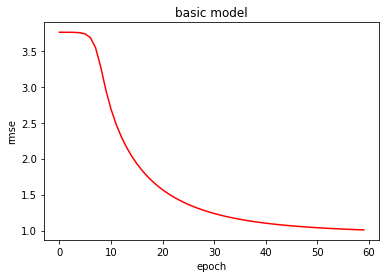

In [10]:
# plot
epoch=[i for i in range(60)]
plt.plot(epoch,rmse_plain,'r') # rmse plot for basic model
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('basic model')
plt.show()

In [11]:
# training procedure: considering bias

rmse_bias=[]
K=30 # number of latent factors
P=np.random.normal(scale=1.0/K,size=(num_user,K)) # user vector
Q=np.random.normal(scale=1.0/K,size=(num_item,K)) # item vector
b_u=np.zeros(num_user) # user bias
b_i=np.zeros(num_item) # item bias
b=np.mean(R_train[np.where(R_train!=0)]) # average rating

# sample where rating is given in training data
samples=[(i,j,R_train[i,j]) for i in range(num_user) for j in range(num_item) if R_train[i,j]>0]
    
for epoch in range(60):
    for i,j,r in samples:
        prediction=rating2(i,j)
        e=r-prediction
        b_u[i]+=0.001*(e-0.01*b_u[i])
        b_i[j]+=0.001*(e-0.01*b_i[j])
        P[i,:]+=0.001*(e*Q[j,:]-0.01*P[i,:])
        Q[j,:]+=0.001*(e*P[i,:]-0.01*Q[j,:])
    R_result2=b+b_u[:,np.newaxis]+b_i[np.newaxis:,]+P@Q.T
    rmse_bias.append(rmse(R_test,R_result2))

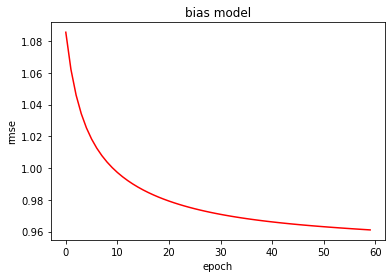

In [12]:
# plot
epoch=[i for i in range(60)]
plt.plot(epoch,rmse_bias,'r') # rmse plot for bias model
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('bias model')
plt.show()

In [13]:
# need to define R(u) set in order to implement neighborhood model
def R_set(i):
    R_set=[]
    for j in range(num_item):
        if R_train[i,j]>0:
            R_set.append(j)
    return R_set

In [14]:
# define diagonal matrix diagR for computation
diagR=np.zeros((num_user,num_user))
for i in range(num_user):
    diagR[i,i]=(len(R_set(i)))**(-0.5)

In [15]:
# training procedure: neighborhood

rmse_neigh=[]
K=30 # number of latent factors
b_u=np.zeros(num_user) # user bias
b_i=np.zeros(num_item) # item bias
b=np.mean(R_train[np.where(R_train!=0)]) # average rating
W=np.zeros((num_item,num_item)) # weight matrix

for epoch in range(60):
    try_num=0
    for i,j,r in samples:
        prediction=rating3(i,j)
        e=r-prediction
        b_u[i]+=0.001*(e-0.01*b_u[i])
        b_i[j]+=0.001*(e-0.01*b_i[j])
        if i==try_num:
            for k in R_set(i):
                W[j,k]+=0.001*(len(R_set(i))**(-0.5)*e*(R_train[i,k]-b-b_u[i]-b_i[k])-0.01*W[j,k])
            try_num+=1
    R_result3=b+b_u[:,np.newaxis]+b_i[np.newaxis:,]+diagR@(R_train-b-b_u[:,np.newaxis]-b_i[np.newaxis:,])@W
    rmse_neigh.append(rmse(R_test,R_result3))

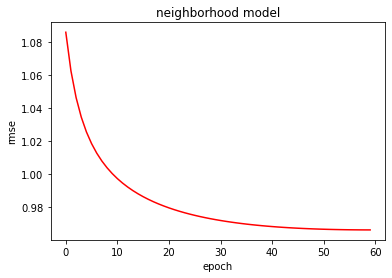

In [16]:
# plot
epoch=[i for i in range(60)]
plt.plot(epoch,rmse_neigh,'r') # rmse plot for neighborhood model
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.title('neighborhood model')
plt.show()

rmse of basic model:  1.0083919109622128
rmse of bias model:  0.9610297267006549
rmse of neighborhood model:  0.9662448339552642


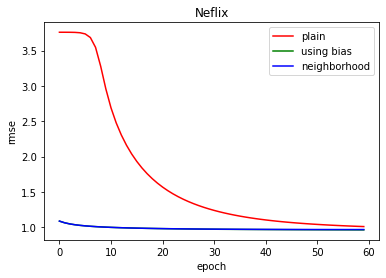

In [17]:
# compare rmse
print("rmse of basic model: ",min(rmse_plain))
print("rmse of bias model: ",min(rmse_bias))
print("rmse of neighborhood model: ",min(rmse_neigh))

# plot together
epoch=[i for i in range(60)]
plt.plot(epoch,rmse_plain,'r') # rmse plot for basic model
plt.plot(epoch,rmse_bias,'g') # rmse plot for bias model
plt.plot(epoch,rmse_neigh,'b') # rmse plot for neighborhood model
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['plain','using bias','neighborhood'])
plt.title('Neflix')
plt.show()